In [11]:
import os
import asyncio
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.core.llms import ChatMessage, ImageBlock

image_urls = [
    "https://picsum.photos/id/1/200/300",
    "https://picsum.photos/id/26/200/300",
]
gemini_pro = GoogleGenAI(model_name="gemini-2.0-flash")
msg = ChatMessage("Is there any relationship between these images?")
for img_url in image_urls:
    msg.blocks.append(ImageBlock(url=img_url))

streaming_handler = await gemini_pro.astream_chat(messages=[msg])
async for chunk in streaming_handler:
    print(chunk.delta, end="")
    await asyncio.sleep(0.5)

Here's a possible relationship between the images:

*   **Thematic Connection:** Both images evoke a sense of modern, stylish, and possibly professional lifestyle. The first image shows someone working on a laptop, likely in a cafe or outdoor setting, while the second image displays a collection of accessories that might be associated with a similar individual.

*   **Personal Items:** The watch in the second image could be the same watch the person is wearing in the first image.

In [ ]:
from pathlib import Path

input_image_path = Path("google_restaurants")
if not input_image_path.exists():
    Path.mkdir(input_image_path)

# !curl -sL "https://docs.google.com/uc?export=download&id=1Pg04p6ss0FlBgz00noHAOAJ1EYXiosKg" -o ./google_restaurants/miami.png
# !curl -sL "https://docs.google.com/uc?export=download&id=1dYZy17bD6pSsEyACXx9fRMNx93ok-kTJ" -o ./google_restaurants/orlando.png
# !curl -sL "https://docs.google.com/uc?export=download&id=1ShPnYVc1iL_TA1t7ErCFEAHT74-qvMrn" -o ./google_restaurants/sf.png
# !curl -sL "https://docs.google.com/uc?export=download&id=1WjISWnatHjwL4z5VD_9o09ORWhRJuYqm" -o ./google_restaurants/toronto.png

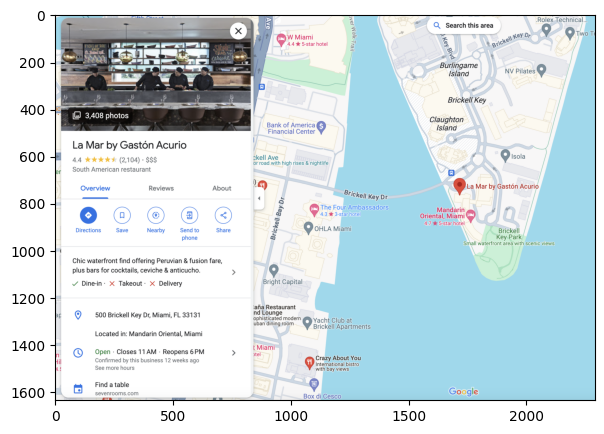

In [1]:
from pydantic import BaseModel
from PIL import Image
import matplotlib.pyplot as plt


class GoogleRestaurant(BaseModel):
    """Data model for a Google Restaurant."""

    restaurant: str
    food: str
    location: str
    category: str
    hours: str
    price: str
    rating: float
    review: str
    description: str
    nearby_tourist_places: str


google_image_url = "./google_restaurants/miami.png"
image = Image.open(google_image_url).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

In [2]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
    can you summarize what is in the image\
    and return the answer with json format \
"""


def pydantic_gemini(
    model_name, output_class, image_documents, prompt_template_str
):
    gemini_llm = GeminiMultiModal(model_name=model_name)

    llm_program = MultiModalLLMCompletionProgram.from_defaults(
        output_parser=PydanticOutputParser(output_class),
        image_documents=image_documents,
        prompt_template_str=prompt_template_str,
        multi_modal_llm=gemini_llm,
        verbose=True,
    )

    response = llm_program()
    return response

In [3]:
from llama_index.core import SimpleDirectoryReader

google_image_documents = SimpleDirectoryReader(
    "./google_restaurants"
).load_data()

results = []
for img_doc in google_image_documents:
    pydantic_response = pydantic_gemini(
        "models/gemini-1.5-flash",
        GoogleRestaurant,
        [img_doc],
        prompt_template_str,
    )
    # only output the results for miami for example along with image
    if "miami" in img_doc.image_path:
        for r in pydantic_response:
            print(r)
    results.append(pydantic_response)

C:\Users\lotto\AppData\Local\Temp\ipykernel_12744\2759973294.py:14: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  gemini_llm = GeminiMultiModal(model_name=model_name)


> Raw output: ```json
{
  "restaurant": "La Mar by Gaston Acurio",
  "food": "Peruvian & fusion",
  "location": "500 Brickell Key Dr, Miami, FL 33131",
  "category": "South American restaurant",
  "hours": "Opens 6PM, Closes 11 PM",
  "price": "$$$",
  "rating": 4.4,
  "review": "Chic waterfront offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticuchos.",
  "description": "Chic waterfront offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticuchos.",
  "nearby_tourist_places": "Brickell Key area with scenic views"
}
```

('restaurant', 'La Mar by Gaston Acurio')
('food', 'Peruvian & fusion')
('location', '500 Brickell Key Dr, Miami, FL 33131')
('category', 'South American restaurant')
('hours', 'Opens 6PM, Closes 11 PM')
('price', '$$$')
('rating', 4.4)
('review', 'Chic waterfront offering Peruvian & fusion fare, plus bars for cocktails, ceviche & anticuchos.')
('description', 'Chic waterfront offering Peruvian & fusion fare, plus bars for cockta

In [4]:
from llama_index.core.schema import TextNode

nodes = []
for res in results:
    text_node = TextNode()
    metadata = {}
    for r in res:
        # set description as text of TextNode
        if r[0] == "description":
            text_node.text = r[1]
        else:
            metadata[r[0]] = r[1]
    text_node.metadata = metadata
    nodes.append(text_node)

In [5]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import Settings
from llama_index.core import StorageContext
import qdrant_client
import os


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
Settings.embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=os.getenv("GOOGLE_API_KEY")
)
Settings.llm = Gemini(api_key=os.getenv("GOOGLE_API_KEY"))

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

C:\Users\lotto\AppData\Local\Temp\ipykernel_12744\3216429639.py:17: DeprecationWarning: Call to deprecated class GeminiEmbedding. (Should use `llama-index-embeddings-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/embeddings/google_genai/)
  Settings.embed_model = GeminiEmbedding(
C:\Users\lotto\AppData\Local\Temp\ipykernel_12744\3216429639.py:20: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  Settings.llm = Gemini(api_key=os.getenv("GOOGLE_API_KEY"))
c:\Users\lotto\anaconda3\envs\fyp\Lib\site-packages\llama_index\vector_stores\qdrant\base.py:703: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


In [6]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
)

response = query_engine.query(
    "recommend a Orlando restaurant for me and its nearby tourist places"
)
print(response)

I recommend Mythos Restaurant, an American restaurant with a mythic underwater theme. It is located at 6000 Universal Blvd, Orlando, FL 32819, United States. Nearby tourist places include Universal Islands and Jurassic Park River Adventure.

